In [2]:
import networkx as nx
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def formatImaris(csvPath):
    '''Function reads in a location path for a CSV data file generated by Imaris and
    returns a pandas datastructure that contains data from CSV file, without additional headers.
    Imaris files will typically have the first three rows dedicated to blank space and formatting
    elements, which are not needed.
    Parameters
    ==========
    csvPath (str) : path to location of CSV file generated by Imaris.  
    
    Returns
    ==========
    (pd.DataFrame) pandas dataframe object with data from supplied CSV at csvPath
    '''
    fileData = []
    with open(csvPath) as csvFile:
        csvReader = csv.reader(csvFile, delimiter=',')
        for i, row in enumerate(csvReader):
            
            if i < 3: # skip unnecessary header
                continue
            elif i == 3: # extract the column names and unpack
                columns = [*row]
            else:
                # Grab all subsequent data rows.
                for row_i, row_item in enumerate(row):
                    try:
                        row[row_i] = float(row_item)
                    except Exception as e:
                        pass
                    else:
                        pass
                    finally:
                        pass
                # append to datastructure.
                fileData.append([*row])
    fileData = pd.DataFrame(fileData, columns = columns, index = None)
    return fileData


def formatIDCSV(csvPath):
    '''Given the path to a CSV file with a single column correlating new IDs to the old
    assigned IMARIS IDs, return a look up table such that new IDs can be substitute for 
    the old IDs.
    Parameters
    ==========
    csvPath (str) : path to location of CSV data file 
    
    Returns
    ==========
    (dict) dictionary with keys as the new IDs, associated values are old IDs.
    '''
    fileData = {}
    with open(csvPath) as csvFile:
        csvReader = csv.reader (csvFile, delimiter = ',')
        for row_i, row in enumerate(csvReader): 
            fileData[row_i] = int(row[-1])
    return fileData


def formatEdgeCSV(csvPath):
    '''Given the path to a CSV file with two columns describing the origin and destination
    of each edge within a directed graph, read in as a numpy ndarray with two columns and
    n rows, where n corresponds to the number of edges.
    Parameters
    ==========
    csvPath (str) : path to location of CSV file  
    
    Returns
    ==========
    (np.ndArray) numpy array object with two columns, first column corresponding to origin nodeID,
        second column corresponding to the destination nodeID.
        All values in the array are int.
    '''
    with open(csvPath) as csvFile:
        csvReader = csv.reader(csvFile, delimiter = ',')
        fileData = [[int(indx) for indx in row] for row in csvReader]
    return np.array(fileData)


def convertEdgeList(newLUT, oldEdgeList):
    '''Given a look up table matching new IDs to old IDs, and a list of edges in the newID format,
    convert the edge list to the old ID format. Basic number substitution in the look up table.
    Parameters
    ==========  
    newLUT (dict) : dictionary object with newID as key, oldID as value.
    oldEdgeList (np.ndArray) : numpy array object, with two columns, first column corresponding 
        to origin nodeID, second column corresponding to the destination nodeID.

    Returns
    ==========
    newEdgeList (np.ndArray) : numpy array object, with two columns, first column corresponding 
        to origin nodeID, second column corresponding to the destination nodeID. Encoding is in 
        new ID format.
    '''
    newEdgeList = np.empty(oldEdgeList.shape)
    for row_i, row in enumerate(oldEdgeList):
        newEdgeList[row_i] = [newLUT[value] for value in row]
    newEdgeList = newEdgeList.astype(int)
    return newEdgeList

In [4]:
def genNetwork(newIDPath, edgeListPath, volPath):
    '''Given the filepaths for 
        1. look up CSV file for matching old IDs to new IDs,
        2. list of edges in the network over time (in new ID format)
        3. data from the volume data 
    return a networkx Digraph object for data traversal.
    Parameters
    ========== 
    newIDPath (str) : path to CSV file for matching old IDs to new IDs
    edgeListPath (str) : path to CSV file with edge data stored in two column format using newID references
    volPath (str) : path to CSV file with volume and time data generated by Imaris using oldID references
    
    Returns
    ==========
    (nx.DiGraph) Networkx directed graph object.
    '''

    # Import existing datafiles into workable data structures
    volumeData = formatImaris(volPath)
    edgeList = formatEdgeCSV(edgeListPath)
    newIDs = formatIDCSV(newIDPath)
    
    # TODO : convert the edgeList to the old ID format using one of the above provided functions.
    edgeList = convertEdgeList(newIDs, edgeList)
    
    # Ignore the following 3 lines for now.
    # Generate dictionary of volumes searchable by original Imaris IDs
    ID2Vol = {int(row.ID) : row.Volume for index, row in volumeData.iterrows()}
    IDTime = {int(row.ID) : row.Time for index, row in volumeData.iterrows()}

    # TODO : Convert the data stored in volumeDatta, edgeList, newIDs into a networkx DiGraph Object.
    G = nx.DiGraph()
    volumeRow = volumeData.shape[0]
    for i in range(volumeRow):
        nodeID = volumeData.at[i, 'ID']
        G.add_node(nodeID, time = IDTime[nodeID], volume = ID2Vol[nodeID])
    G.add_edges_from(edgeList)


    nodeSizeList = [1000* i for i in nx.get_node_attributes(G,'volume').values()]
    nodeColorID = list(IDTime.values())
    plt.figure(figsize = [15,15])
    nx.draw_networkx(G, node_color = nodeColorID,node_size = nodeSizeList, with_labels=True, cmap=plt.cm.Blues)    
    plt.show()
    
    return G
    #raise NotImplementedError

In [56]:
def getLinearEdges(nxGraph):
    '''
    Given a nxGraph directed graph object, traverse all edges in the graph, 
    and return a list of edges that form a path with one another only; 
    in other words, two nodes such that the parent node has only one child, 
    and the child node has only a single parent.
    Parameters
    ==========
    nxGraph (nx.DiGraph) : networkx directed graph object.

    Returns
    ==========
    (np.ndarray) two column np.ndarray, with int values for origin and destination 
    node for each edge that satisfies stated requirement.
    '''

    # TODO : Implement function
    linearEdges = np.zeros((nxGraph.number_of_edges(), 2)) #to store linear edge pairs with extra room
    edgesDict = {} #empty dictionary to store edges with unique child
    deletedEdges = [] #list with deleted edges that don't have only one child
    
    for (p, c) in nxGraph.edges():
        if p not in edgesDict and p not in deletedEdges:
            edgesDict[p] = c #adding pair to dictionary if unique child exists
        elif p in edgesDict:
            deletedEdges.append(p)
            del edgesDict[p] #delete pair if a parent has multiple children
            
    finalEdgesDict= {} #empty new dictionary to store linear edge pairs
    deletedEdges2 = [] #list with deleted edges that don't have unique parents
    for k, v in edgesDict.items():
        if v not in finalEdgesDict and v not in deletedEdges2:
            finalEdgesDict[v] = k #adding pair to dictionary if unique parent exists
        elif v in finalEdgesDict:
            deletedEdges2.append(v)
            del finalEdgesDict[v] #delete pair if a child has multiple parents
            
    linearEdgesRow = 0
    for k, v in finalEdgesDict.items():
        linearEdges[linearEdgesRow] = [v, k] #adding linear edge pairs to ndarray with extra room
        linearEdgesRow = linearEdgesRow + 1
        
    finalLinearEdges = np.zeros((linearEdgesRow, 2))
    finalLinearEdgesRow = 0
    for i in range(linearEdgesRow):
        finalLinearEdges[finalLinearEdgesRow] = linearEdges[finalLinearEdgesRow] #copying over linear edge pairs to ndarray without extra room
        finalLinearEdgesRow = finalLinearEdgesRow + 1
    return finalLinearEdges
    #raise NotImplementedError

# Run Test Cases

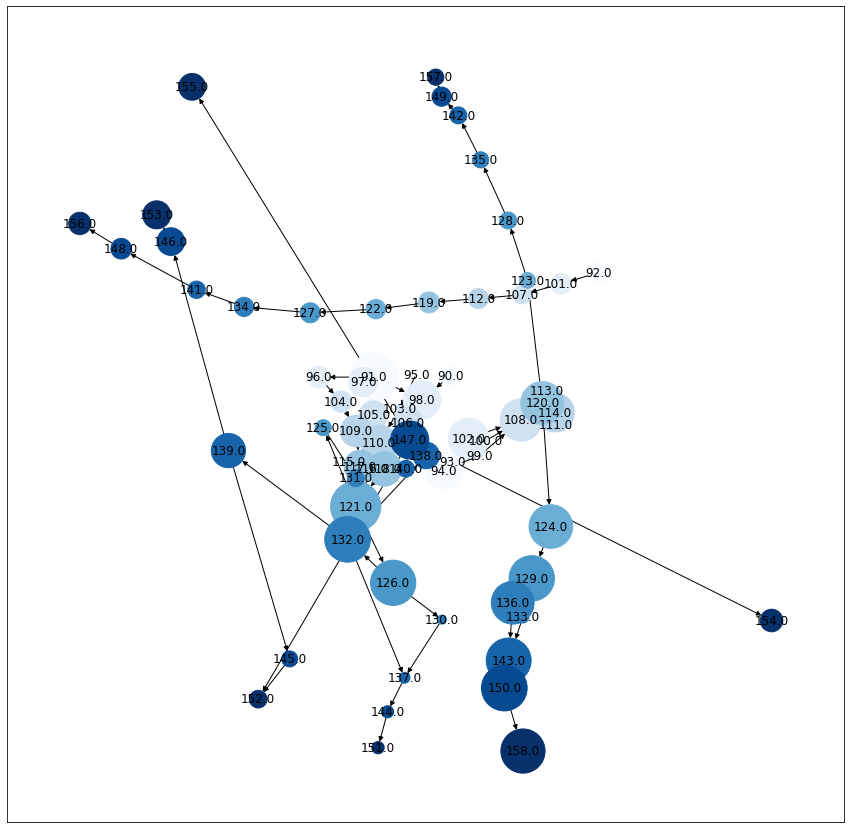

array([[ 90.,  98.],
       [ 92., 101.],
       [ 95., 103.],
       [ 96., 104.],
       [ 97., 105.],
       [101., 107.],
       [104., 109.],
       [107., 112.],
       [109., 117.],
       [112., 119.],
       [119., 122.],
       [122., 127.],
       [123., 128.],
       [124., 129.],
       [125., 131.],
       [127., 134.],
       [128., 135.],
       [130., 137.],
       [131., 140.],
       [134., 141.],
       [135., 142.],
       [137., 144.],
       [141., 148.],
       [142., 149.],
       [143., 150.],
       [144., 151.],
       [145., 152.],
       [146., 153.],
       [148., 156.],
       [149., 157.],
       [150., 158.]])

In [57]:
test_network = genNetwork(newIDPath = "MTSmCh000y002_newIds.csv",
                            edgeListPath = "MTSmCh000y002_connections.csv",
                            volPath = "MTSmCh000y002_SURFVolume.csv")


#plt.figure(figsize = [15,15])
#nx.draw_networkx(test_network)
#plt.show()
getLinearEdges(test_network)

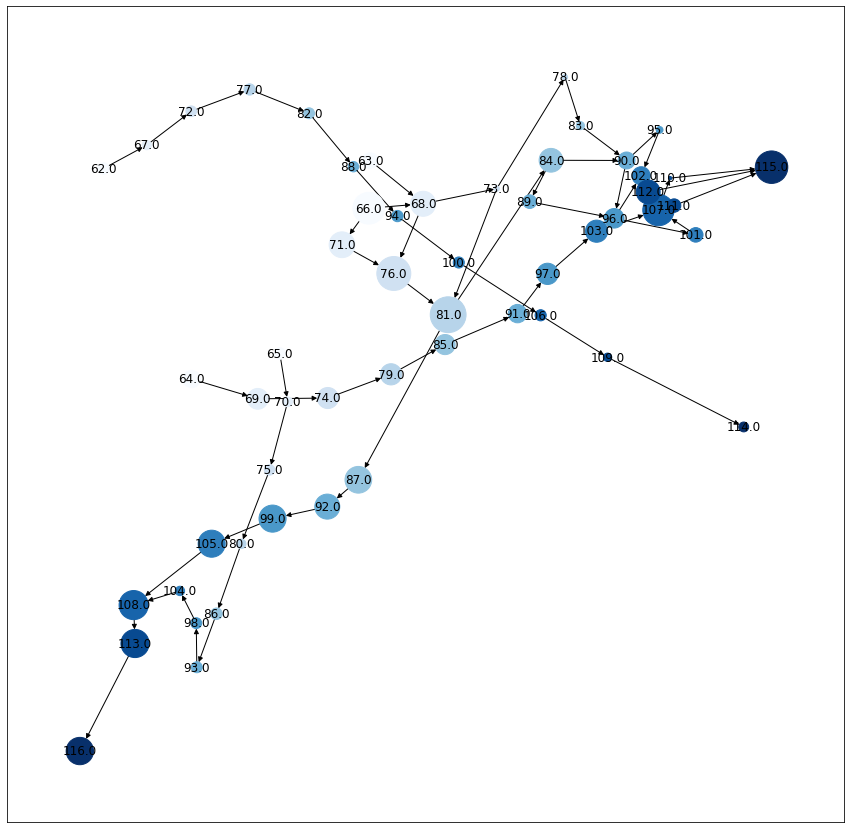

In [31]:
test_network2 = genNetwork(newIDPath = "MTSmCh000y001_newIds.csv",
                            edgeListPath = "MTSmCh000y001_connections.csv",
                            volPath = "MTSmCh000y001_SURFVolume.csv")


#plt.figure(figsize = [15,15])
#nx.draw_networkx(test_network)    
#plt.show()